## HORUS-NER: Text Classification (v1.0)

## Get training data from DBPedia

In [2]:
import requests
import json
import csv
import pandas as pd
import io
from SPARQLWrapper import SPARQLWrapper, JSON, CSV, TSV
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
import joblib
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

In [3]:
sentence = 'Then discover the Fiat 500C, the iconic city car that is as individual as you'

## Defining SPARQL queries

In [4]:
endpoint = 'https://dbpedia.org/sparql'

query_sufix = """
offset <offset>
limit 10000
"""
query_namespaces = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

"""
query_per = """
SELECT ?s, ?label, dbo:Person as ?type, ?abstract
FROM <http://dbpedia.org>
WHERE {
    ?s rdf:type dbo:Person .
    ?s rdfs:label ?label .
    ?s dbo:abstract ?abstract .
    FILTER (lang(?label) = 'en') .
    FILTER (lang(?abstract) = 'en')
}
"""

query_loc = """
SELECT ?s, ?label, ?type, ?abstract
FROM <http://dbpedia.org>
WHERE {
    ?s rdf:type ?type . 
    ?s rdfs:label ?label .
    ?s dbo:abstract ?abstract .
    FILTER (lang(?abstract) = 'en')
    FILTER (lang(?label) = 'en')
    FILTER (?type IN (dbo:City, dbo:Country, dbo:Towns, dbo:Municipality, dbo:Hill_station, dbo:Village, dbo:Suburb, dbo:Neighborhood, dbo:NaturalPlace, dbo:Urban_areas, dbo:Tourist_attraction)) 
}
"""

query_org = """
SELECT ?s, ?label, ?type, ?abstract
FROM <http://dbpedia.org>
WHERE { ?s rdf:type ?type .
        ?s rdfs:label ?label .
        ?s dbo:abstract ?abstract .
    FILTER (lang(?abstract) = 'en')
    FILTER (lang(?label) = 'en')
    FILTER (?type IN (dbo:Organisation, dbo:Company)) 
}
"""    

query_others = """
SELECT ?s, ?label, ?type, ?abstract
FROM <http://dbpedia.org>
WHERE {
    ?s rdf:type ?type . 
    ?s rdfs:label ?label .
    ?s dbo:abstract ?abstract .
    FILTER (lang(?abstract) = 'en')
    FILTER (lang(?label) = 'en')
    FILTER (?type IN (dbo:WrittenWork, dbo:Species, dbo:CelestialBody, dbo:Food, dbo:Disease, dbo:Game, dbo:MeanOfTransportation)) 
}
"""

## Saving data from DBPedia

In [5]:
# limit is fixed to its default: 10000
offsets = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]

sparql = SPARQLWrapper("http://dbpedia.org/sparql")
Q = [('person', query_per), ('location', query_loc), ('organisation', query_org), ('other', query_others)]
for (label, query) in Q:
    for offset in offsets:
        print(label, offset)
        file_sufix = '0' + str(offset)[0]
        if len(str(offset))==6: 
            file_sufix = str(offset)[0:2]
        path = f'./data/raw/dump_dbpedia_{label}_{file_sufix}.csv'
        if not os.path.isfile(path):
            sparql.setQuery(query_namespaces + query + query_sufix.replace('<offset>', str(offset)))
            sparql.setReturnFormat(TSV)
            results = sparql.query().convert()
            df = pd.read_csv(io.BytesIO(results), sep="\t") 
            df.to_csv(path, sep='\t')

person 0
person 10000
person 20000
person 30000
person 40000
person 50000
person 60000
person 70000
person 80000
person 90000
person 100000
location 0
location 10000
location 20000
location 30000
location 40000
location 50000
location 60000
location 70000
location 80000
location 90000
location 100000
organisation 0
organisation 10000
organisation 20000
organisation 30000
organisation 40000
organisation 50000
organisation 60000
organisation 70000
organisation 80000
organisation 90000
organisation 100000
other 0
other 10000
other 20000
other 30000
other 40000
other 50000
other 60000
other 70000
other 80000
other 90000
other 100000


In [6]:
df_per0 = pd.read_csv('./data/raw/dump_dbpedia_person_00.csv', sep='\t', index_col=0)
df_per1 = pd.read_csv('./data/raw/dump_dbpedia_person_01.csv', sep='\t', index_col=0)
"""
df_per2 = pd.read_csv('./data/raw/dump_dbpedia_person_02.csv', sep='\t', index_col=0)
df_per3 = pd.read_csv('./data/raw/dump_dbpedia_person_03.csv', sep='\t', index_col=0)
df_per4 = pd.read_csv('./data/raw/dump_dbpedia_person_04.csv', sep='\t', index_col=0)
df_per5 = pd.read_csv('./data/raw/dump_dbpedia_person_05.csv', sep='\t', index_col=0)
df_per6 = pd.read_csv('./data/raw/dump_dbpedia_person_06.csv', sep='\t', index_col=0)
df_per7 = pd.read_csv('./data/raw/dump_dbpedia_person_07.csv', sep='\t', index_col=0)
df_per8 = pd.read_csv('./data/raw/dump_dbpedia_person_08.csv', sep='\t', index_col=0)
df_per9 = pd.read_csv('./data/raw/dump_dbpedia_person_09.csv', sep='\t', index_col=0)
df_per10 = pd.read_csv('./data/raw/dump_dbpedia_person_10.csv', sep='\t', index_col=0)
"""

df_org0 = pd.read_csv('./data/raw/dump_dbpedia_organisation_00.csv', sep='\t', index_col=0)
df_org1 = pd.read_csv('./data/raw/dump_dbpedia_organisation_01.csv', sep='\t', index_col=0)
"""
df_org2 = pd.read_csv('./data/raw/dump_dbpedia_organisation_02.csv', sep='\t', index_col=0)
df_org3 = pd.read_csv('./data/raw/dump_dbpedia_organisation_03.csv', sep='\t', index_col=0)
df_org4 = pd.read_csv('./data/raw/dump_dbpedia_organisation_04.csv', sep='\t', index_col=0)
df_org5 = pd.read_csv('./data/raw/dump_dbpedia_organisation_05.csv', sep='\t', index_col=0)
df_org6 = pd.read_csv('./data/raw/dump_dbpedia_organisation_06.csv', sep='\t', index_col=0)
df_org7 = pd.read_csv('./data/raw/dump_dbpedia_organisation_07.csv', sep='\t', index_col=0)
df_org8 = pd.read_csv('./data/raw/dump_dbpedia_organisation_08.csv', sep='\t', index_col=0)
df_org9 = pd.read_csv('./data/raw/dump_dbpedia_organisation_09.csv', sep='\t', index_col=0)
df_org10 = pd.read_csv('./data/raw/dump_dbpedia_organisation_10.csv', sep='\t', index_col=0)
"""

df_loc0 = pd.read_csv('./data/raw/dump_dbpedia_location_00.csv', sep='\t', index_col=0)
df_loc1 = pd.read_csv('./data/raw/dump_dbpedia_location_01.csv', sep='\t', index_col=0)
"""
df_loc2 = pd.read_csv('./data/raw/dump_dbpedia_location_02.csv', sep='\t', index_col=0)
df_loc3 = pd.read_csv('./data/raw/dump_dbpedia_location_03.csv', sep='\t', index_col=0)
df_loc4 = pd.read_csv('./data/raw/dump_dbpedia_location_04.csv', sep='\t', index_col=0)
df_loc5 = pd.read_csv('./data/raw/dump_dbpedia_location_05.csv', sep='\t', index_col=0)
df_loc6 = pd.read_csv('./data/raw/dump_dbpedia_location_06.csv', sep='\t', index_col=0)
df_loc7 = pd.read_csv('./data/raw/dump_dbpedia_location_07.csv', sep='\t', index_col=0)
df_loc8 = pd.read_csv('./data/raw/dump_dbpedia_location_08.csv', sep='\t', index_col=0)
df_loc9 = pd.read_csv('./data/raw/dump_dbpedia_location_09.csv', sep='\t', index_col=0)
df_loc10 = pd.read_csv('./data/raw/dump_dbpedia_location_10.csv', sep='\t', index_col=0)
"""
df_other0 = pd.read_csv('./data/raw/dump_dbpedia_other_00.csv', sep='\t', index_col=0)
df_other1 = pd.read_csv('./data/raw/dump_dbpedia_other_01.csv', sep='\t', index_col=0)
"""
df_other2 = pd.read_csv('./data/raw/dump_dbpedia_other_02.csv', sep='\t', index_col=0)
df_other3 = pd.read_csv('./data/raw/dump_dbpedia_other_03.csv', sep='\t', index_col=0)
df_other4 = pd.read_csv('./data/raw/dump_dbpedia_other_04.csv', sep='\t', index_col=0)
df_other5 = pd.read_csv('./data/raw/dump_dbpedia_other_05.csv', sep='\t', index_col=0)
df_other6 = pd.read_csv('./data/raw/dump_dbpedia_other_06.csv', sep='\t', index_col=0)
df_other7 = pd.read_csv('./data/raw/dump_dbpedia_other_07.csv', sep='\t', index_col=0)
df_other8 = pd.read_csv('./data/raw/dump_dbpedia_other_08.csv', sep='\t', index_col=0)
df_other9 = pd.read_csv('./data/raw/dump_dbpedia_other_09.csv', sep='\t', index_col=0)
df_other10 = pd.read_csv('./data/raw/dump_dbpedia_other_10.csv', sep='\t', index_col=0)
"""

"\ndf_other2 = pd.read_csv('./data/raw/dump_dbpedia_other_02.csv', sep='\t', index_col=0)\ndf_other3 = pd.read_csv('./data/raw/dump_dbpedia_other_03.csv', sep='\t', index_col=0)\ndf_other4 = pd.read_csv('./data/raw/dump_dbpedia_other_04.csv', sep='\t', index_col=0)\ndf_other5 = pd.read_csv('./data/raw/dump_dbpedia_other_05.csv', sep='\t', index_col=0)\ndf_other6 = pd.read_csv('./data/raw/dump_dbpedia_other_06.csv', sep='\t', index_col=0)\ndf_other7 = pd.read_csv('./data/raw/dump_dbpedia_other_07.csv', sep='\t', index_col=0)\ndf_other8 = pd.read_csv('./data/raw/dump_dbpedia_other_08.csv', sep='\t', index_col=0)\ndf_other9 = pd.read_csv('./data/raw/dump_dbpedia_other_09.csv', sep='\t', index_col=0)\ndf_other10 = pd.read_csv('./data/raw/dump_dbpedia_other_10.csv', sep='\t', index_col=0)\n"

In [7]:
df_per0.head()

,s,label,type,abstract
0,http://dbpedia.org/resource/Andreas_Ekberg,Andreas Ekberg,http://dbpedia.org/ontology/Person,Andreas Ekberg (born 2 January 1985) is a Swed...
1,http://dbpedia.org/resource/Danilo_Tognon,Danilo Tognon,http://dbpedia.org/ontology/Person,"The Canoeist Danilo Tognon (born October 9, 19..."
2,http://dbpedia.org/resource/Lorine_Livington_P...,Lorine Livington Pruette,http://dbpedia.org/ontology/Person,Lorine Livington Pruette (1896–1977) was an Am...
3,http://dbpedia.org/resource/Megan_Lawrence,Megan Lawrence,http://dbpedia.org/ontology/Person,Megan Lawrence (born 1972) is an American actr...
4,http://dbpedia.org/resource/Nikolaos_Ventouras,Nikolaos Ventouras,http://dbpedia.org/ontology/Person,"Nikos Ventouras (August 31, 1899 – April 1, 19..."


## Training data

In [8]:
#aux = [df_per0, df_per1, df_per2, df_per3, df_per4, df_per5, df_per6, df_per7, df_per8, df_per9, df_per10]
aux = [df_per0, df_per1]
df_per = pd.concat(aux)
print('PERSON', df_per.shape)
df_per.drop_duplicates(subset ="label", keep = False, inplace = True) 
print(df_per.shape)
df_per.to_csv('./data/processed/dump_dbpedia_person.csv', sep='\t')

#aux = [df_org0, df_org1, df_org2, df_org3, df_org4, df_org5, df_org6, df_org7, df_org8, df_org9, df_org10]
aux = [df_org0, df_org1]
df_org = pd.concat(aux)
print('ORGANISATION', df_org.shape)
df_org.drop_duplicates(subset ="label", keep = False, inplace = True) 
print(df_org.shape)
df_org.to_csv('./data/processed/dump_dbpedia_organisation.csv', sep='\t')

#aux = [df_loc0, df_loc1, df_loc2, df_loc3, df_loc4, df_loc5, df_loc6, df_loc7, df_loc8, df_loc9, df_loc10]
aux = [df_loc0, df_loc1]
df_loc = pd.concat(aux)
print('LOCATION', df_loc.shape)
df_loc.drop_duplicates(subset ="label", keep = False, inplace = True) 
print(df_loc.shape)
df_loc.to_csv('./data/processed/dump_dbpedia_location.csv', sep='\t')

#aux = [df_other0, df_other1, df_other2, df_other3, df_other4, df_other5, df_other6, df_other7, df_other8, df_other9, df_other10]
aux = [df_other0, df_other1]
df_other = pd.concat(aux)
print('OTHER', df_other.shape)
df_other.drop_duplicates(subset ="label", keep = False, inplace = True) 
print(df_other.shape)
df_other.to_csv('./data/processed/dump_dbpedia_other.csv', sep='\t')

PERSON (20000, 4)
(20000, 4)
ORGANISATION (20000, 4)
(12292, 4)
LOCATION (20000, 4)
(20000, 4)
OTHER (20000, 4)
(19970, 4)


In [9]:
# adding the label class
df_per['category'] = 'PER'
df_org['category'] = 'ORG'
df_loc['category'] = 'LOC'
df_other['category'] = 'OTHER'

In [10]:
training_data = [df_per, df_org, df_loc, df_other]
df_train = pd.concat(training_data, ignore_index=True, keys=["s", "label", "type", "abstract", "category"])
df_train.reset_index(drop=True)
df_train.groupby('category').s.count()

category
LOC      20000
ORG      12292
OTHER    19970
PER      20000
Name: s, dtype: int64

In [11]:
df_train['category_id'], uniques = df_train['category'].factorize()
#df_train.set_index(['s', 'y'])
#columns = ["s", "label", "type", "abstract", "y"]
#df_train = df_train.reindex(columns=columns)
#df_train[columns] = df_train[columns].astype(int)

In [12]:
uniques

Index(['PER', 'ORG', 'LOC', 'OTHER'], dtype='object')

In [13]:
category_id_df = df_train[['category', 'category_id']].drop_duplicates().sort_values('category_id')

In [14]:
category_id_df

,category,category_id
0,PER,0
20000,ORG,1
32292,LOC,2
52292,OTHER,3


In [15]:
category2idx = dict(category_id_df.values)
idx2category = dict(category_id_df[['category_id', 'category']].values)
joblib.dump((category2idx, idx2category), 'encoder_4MUC_cat2id_id2cat.joblib')

['encoder_4MUC_cat2id_id2cat.joblib']

In [16]:
category2idx

{'PER': 0, 'ORG': 1, 'LOC': 2, 'OTHER': 3}

In [17]:
idx2category

{0: 'PER', 1: 'ORG', 2: 'LOC', 3: 'OTHER'}

In [18]:
idx2category[0]

'PER'

In [ ]:
df_train.head()

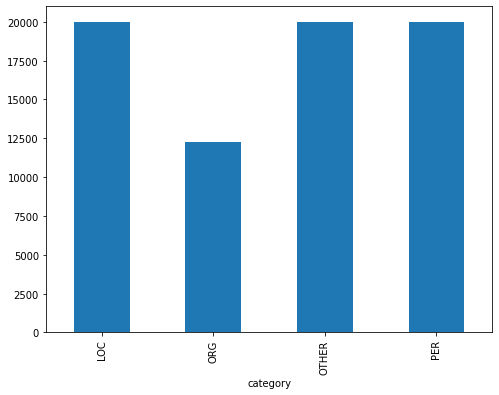

In [14]:
fig = plt.figure(figsize=(8,6))
df_train.groupby('category').label.count().plot.bar(ylim=0)
plt.show()

## Feature Extraction

In [258]:
X_train, X_test, y_train, y_test, indices_train, indices_test =\
    train_test_split(df_train['abstract'].astype(str), 
                     df_train['category_id'], 
                     df_train.index,
                     test_size=0.33,
                     random_state=0)
#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_train)
#tfidf_transformer = TfidfTransformer()
#X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [259]:
stat1 = y_train.groupby(lambda x: y_train[x])
stat2 = y_test.groupby(lambda x: y_test[x])

In [260]:
stat1.size()

0    13451
1     8275
2    13324
3    13365
Name: category_id, dtype: int64

In [261]:
stat2.size()

0    6549
1    4017
2    6676
3    6605
Name: category_id, dtype: int64

In [262]:
NR_MAX_FEATURES = 5000
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        use_idf=True,
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words=stop_words,
                        max_features=NR_MAX_FEATURES)
features_train = tfidf.fit_transform(X_train) #.toarray()
features_test = tfidf.transform(X_test)
#labels_train = df_train.category_id
joblib.dump(tfidf, 'feature_extract_tfidf_ngram2_' + str(NR_MAX_FEATURES) + '.joblib')
# total of abstracts x nr. of features per abstract

['feature_extract_tfidf_ngram2_5000.joblib']

In [263]:
features.shape

(72262, 5000)

In [264]:
N = 2
for category, category_id in sorted(category_to_id.items()):
    break
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

### Train, Test sets.

In [265]:
clf = MultinomialNB().fit(features_train, y_train)

In [266]:
type(X_train)

pandas.core.series.Series

In [267]:
print(clf.predict(tfidf.transform(["Diego was born in Mars and currently lives in Venus, which is a city located at Polo."])))

[2]


In [268]:
len(labels)

72262

## Benchmark

In [269]:
models = [
    #RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    CalibratedClassifierCV(LinearSVC()),
    #LogisticRegression(random_state=0)
    LogisticRegression(multi_class="multinomial", solver="sag", C=5, random_state=0)
]
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, features_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        print(fold_idx, accuracy)
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

LinearSVC
0 0.9573703451267117
1 0.9610856363861693
2 0.9594125666129631
CalibratedClassifierCV
0 0.9592291963566516
1 0.9624488784235965
2 0.9604659809146114
LogisticRegression
0 0.9582997707416816
1 0.9618292229520387
2 0.9591027388771843


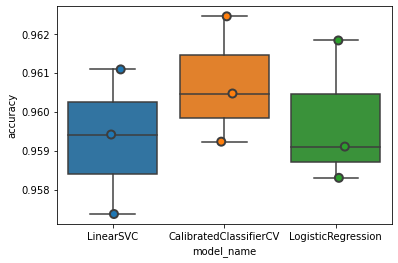

In [270]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [271]:
cv_df.groupby('model_name').accuracy.mean()

model_name
CalibratedClassifierCV    0.960715
LinearSVC                 0.959290
LogisticRegression        0.959744
Name: accuracy, dtype: float64

## Model Evaluation

### Shared functions

['PER', 'ORG', 'LOC', 'OTHER']

In [282]:
def print_train_test_save_print(cls, cls_label, sentence, multik_prob: bool = True):
    print('training')
    cls.fit(features_train, y_train)
    print('saving')
    joblib.dump(cls, cls_label)
    print('predict')
    y_pred = cls.predict(features_test)
    print('report')
    conf_mat = prot_matrix(y_test, y_pred, category_id_df.category.values, category_id_df.category.values)
    print()
    print(metrics.classification_report(y_test, y_pred, target_names=list(category2idx.keys())))
    print()
    x = tfidf.transform([sentence])
    if multik_prob:
        out = [(round(p, 3)) for p in cls.predict_proba(x)[0]]
    else:
        out = cls.predict(x)
    print(out)

In [284]:
def prot_matrix(y_test, y_pred, xticklabels, yticklabels):
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=xticklabels, yticklabels=yticklabels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return conf_mat

### CalibratedClassifierCV

training
saving
predict
report


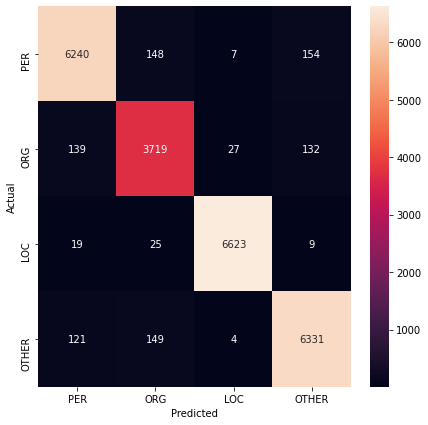


              precision    recall  f1-score   support

         PER       0.96      0.95      0.96      6549
         ORG       0.92      0.93      0.92      4017
         LOC       0.99      0.99      0.99      6676
       OTHER       0.96      0.96      0.96      6605

    accuracy                           0.96     23847
   macro avg       0.96      0.96      0.96     23847
weighted avg       0.96      0.96      0.96     23847


[0.0, 0.001, 0.754, 0.245]


In [291]:
cls_calibrated = CalibratedClassifierCV(LinearSVC())

print_train_test_save_print(cls=cls_calibrated, 
                            cls_label='multi_cls-calib_linear.joblib',
                            sentence=sentence,
                            multik_prob=True)

### One-vs-all (OvR) strategy

training
saving
predict
report


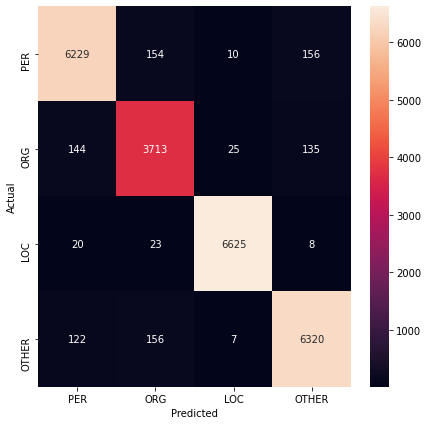


              precision    recall  f1-score   support

         PER       0.96      0.95      0.95      6549
         ORG       0.92      0.92      0.92      4017
         LOC       0.99      0.99      0.99      6676
       OTHER       0.95      0.96      0.96      6605

    accuracy                           0.96     23847
   macro avg       0.96      0.96      0.96     23847
weighted avg       0.96      0.96      0.96     23847


[2]


In [286]:
ovr_linear = OneVsRestClassifier(LinearSVC(), n_jobs=-1)

print_train_test_save_print(cls=ovr_linear, 
                            cls_label='ovr_cls-linearSVC.joblib',
                            sentence=sentence,
                            multik_prob=False)

### XGBoost

training
saving
predict
report


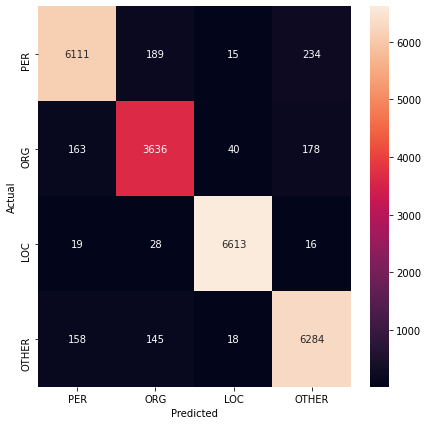


              precision    recall  f1-score   support

         PER       0.95      0.93      0.94      6549
         ORG       0.91      0.91      0.91      4017
         LOC       0.99      0.99      0.99      6676
       OTHER       0.94      0.95      0.94      6605

    accuracy                           0.95     23847
   macro avg       0.95      0.95      0.95     23847
weighted avg       0.95      0.95      0.95     23847


[0.023, 0.033, 0.888, 0.055]


In [287]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", 
                              num_class=4, 
                              max_depth=5, 
                              random_state=42)

print_train_test_save_print(cls=xgb_model, 
                            cls_label='multi_cls-xgboost.joblib',
                            sentence=sentence,
                            multik_prob=True)

## Feature Selection Analysis

In [288]:
for predicted in category_id_df.category_id:
    break
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' pred as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df_train.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'abstract']])
            print('')

In [289]:
#model.fit(features, labels)
N = 2
for category, category_id in sorted(category_to_id.items()):
    break
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(category))
    print("  top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [290]:
len(subset.abstract.values)

20000

In [53]:
subset = df_train[df_train.category=='PER']

In [62]:
d = {}
i = 0 
for text in subset.abstract.values:
    print(text)
    break
    print(i)
    i+=1
    if i == 100:
        break
    tokens = word_tokenize(text)
    tokens_without_sw = [word.lower() for word in tokens if not word.lower() in stopwords.words()]
    for token in tokens_without_sw:
        d[token] = d.get(token, 0) + 1

Andreas Ekberg (born 2 January 1985) is a Swedish football referee. Ekberg currently resides in Malmö. He has been a full international referee for FIFA since 2013. He became a professional referee in 2004 and has been an Allsvenskan referee since 2009. Ekberg has refereed 74 matches in Allsvenskan, 55 matches in Superettan and 14 international matches as of 2014.


In [101]:
'.' in stopwords.words()

False

In [58]:
#173498
len(d) 

2697

In [100]:
i = 0
for k in sorted(d, key=d.get, reverse=True):
    print(k, d[k])
    i += 1
    if i > 10:
        break

In [66]:
categories = set(list(df_train.category))

In [79]:
df_train.category

'PER'